<a href="https://colab.research.google.com/github/ChristopheGraveline064/CDA_mesurement/blob/main/cda_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

datapath = '/content/drive/MyDrive/aerostick_data/'

# Load your CSV
df_feature = pd.read_csv(os.path.join(datapath, 'tmp-AIDetail.csv'))
display(df_feature)
df_target = pd.read_csv(os.path.join(datapath, 'targets-Sheet1.csv'))
display(df_target)
# Drop non-feature columns if needed
# df = df.drop(columns=['non_feature_column'])


data = df.values.astype(np.float32)
cda = df_target.values.astype(np.float32)


,i,dist,power,speed,air
0,0,0.00,75,6.34,2.359
1,1,10.40,75,6.34,14.112
2,2,6.24,76,6.37,17.988
3,3,4.16,76,6.42,19.659
4,4,6.24,115,6.48,22.411
...,...,...,...,...,...
2792,2792,0.00,0,0.14,0.000
2793,2793,0.00,0,0.14,0.000
2794,2794,0.00,0,0.14,0.000
2795,2795,0.00,0,0.14,0.000


,start,end,start.1,end.1,cda
0,90,233,314,450,0.261
1,533,676,745,887,0.268
2,953,1092,1173,1314,0.264
3,1475,1619,1667,1818,0.270
4,1887,2029,2080,2228,0.272
5,2305,2445,2512,2654,0.270


#Data Processing

In [ ]:
import tensorflow as tf
import numpy as np

features = []
targets = []

target_column = -1  # Assuming this is where your target/label is in cda

for i in range(len(cda)):
    # Extract the label
    label = cda[i, target_column]

    # Extract the variable-length sequence (rows from data)
    seq1 = data[int(cda[i, 0]):int(cda[i, 1]), 1:]  # skip column 0, use all others
    seq2 = data[int(cda[i, 2]):int(cda[i, 3]), 1:]
    sequence = np.concatenate([seq1, seq2], axis=0)

    features.append(sequence)  # variable-length 2D array
    targets.append(label)

    #sequence = data[int(cda[i, 2]):int(cda[i, 3]), 1:]
    #features.append(sequence)  # variable-length 2D array
    #targets.append(label)

# ✅ Convert features to a RaggedTensor
ragged_features = tf.ragged.constant(features, dtype=tf.float32)

# ✅ Convert targets to a normal tensor
targets = tf.convert_to_tensor(targets, dtype=tf.float32)



In [ ]:
# Pad the ragged features
padded_features = ragged_features.to_tensor(default_value=0.0)

#convert  to numpy
padded_features_np = padded_features.numpy()
targets_np = targets.numpy()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_features_np, targets_np, test_size=0.2, random_state=42)

#Model

In [146]:
import tensorflow as tf

model_type = 'RNN'

if model_type == 'RNN':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(1)
  ])
elif model_type == 'LSTM':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(1)
  ])
elif model_type == 'GRU':
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, padded_features_np.shape[2])),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Train

In [147]:
history = model.fit(X_train, y_train, epochs=75, batch_size=4, validation_data=(X_test, y_test))

Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 2.7917 - mae: 1.1555 - val_loss: 0.0660 - val_mae: 0.2227
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 2.2915 - mae: 0.9525 - val_loss: 0.1261 - val_mae: 0.3235
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 1.9420 - mae: 0.7751 - val_loss: 0.1871 - val_mae: 0.4031
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1.7005 - mae: 0.6849 - val_loss: 0.2394 - val_mae: 0.4600
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.5053 - mae: 0.7201 - val_loss: 0.2754 - val_mae: 0.4908
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.3023 - mae: 0.7120 - val_loss: 0.2936 - val_mae: 0.4982
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 1.0744 - mae: 0.6673 - val_loss: 0.2969 - val_mae: 0.4885
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.8410 - mae: 0.5949 - val_loss: 0.2898 - val_mae: 0.4674
Epoch 9/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.6316 - mae: 0.5

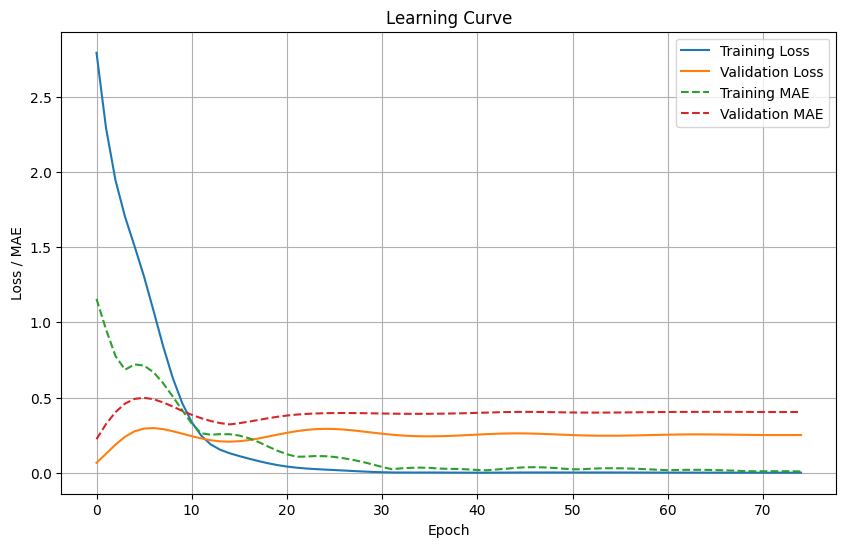

In [148]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Optional: plot additional metrics like MAE
if 'mae' in history.history:
    plt.plot(history.history['mae'], label='Training MAE', linestyle='--')
    plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')

plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend()
plt.grid(True)
plt.show()


#Evaluate

In [ ]:
model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1.6026e-04 - mae: 0.0125


[0.00016026363300625235, 0.01250477135181427]

Sequance A->B or B->A: \\
RNN: [0.04569952189922333, 0.1260969489812851] \\
LSTM: [0.006350232753902674, 0.05139995738863945] \\
GRU: [0.0006004805327393115, 0.016981273889541626] \\

Sequance A->B->A \\
RNN: [0.0014131211210042238, 0.03691475838422775] \\
LSTM: [0.00016026363300625235, 0.01250477135181427] \\
GRU: [7.255527634697501e-06, 0.002303078770637512]

##RNN (epoch: 75, batch size: 4):

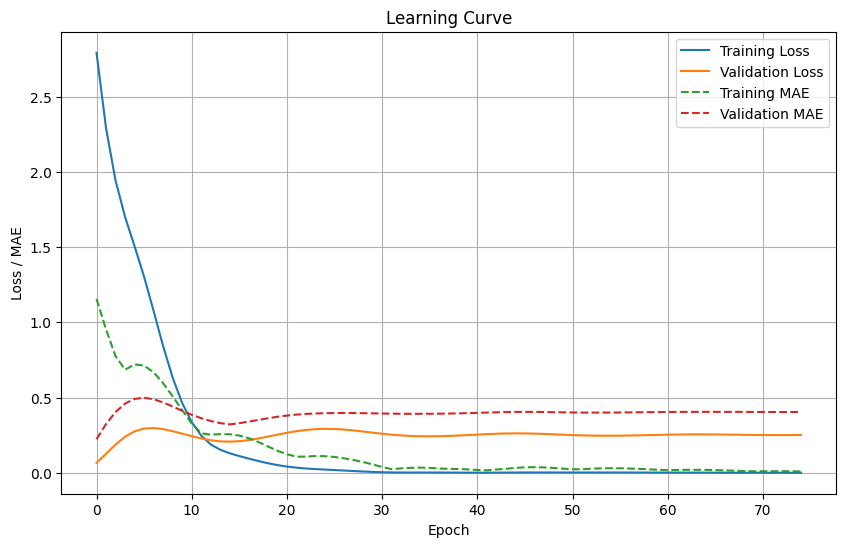

##LSTM (epoch: 75, batch size: 4)

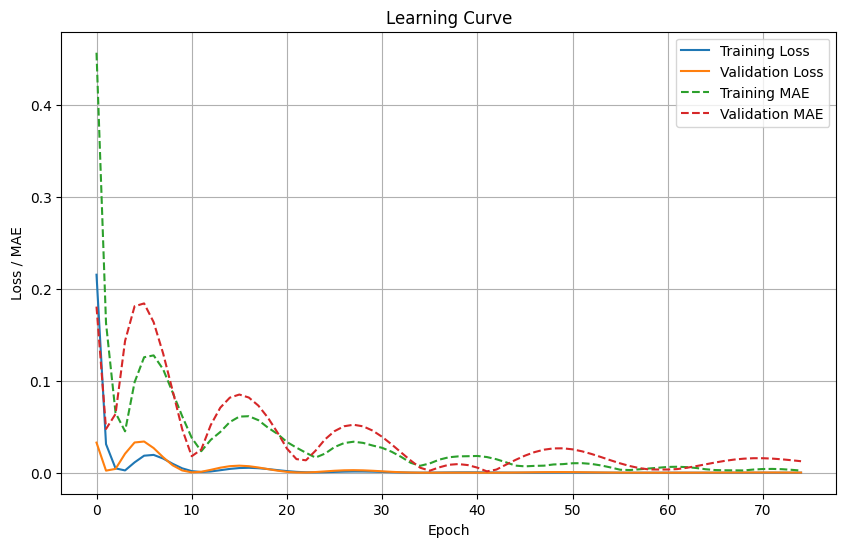

##GRU (ephoch: 75, batch size: 4)

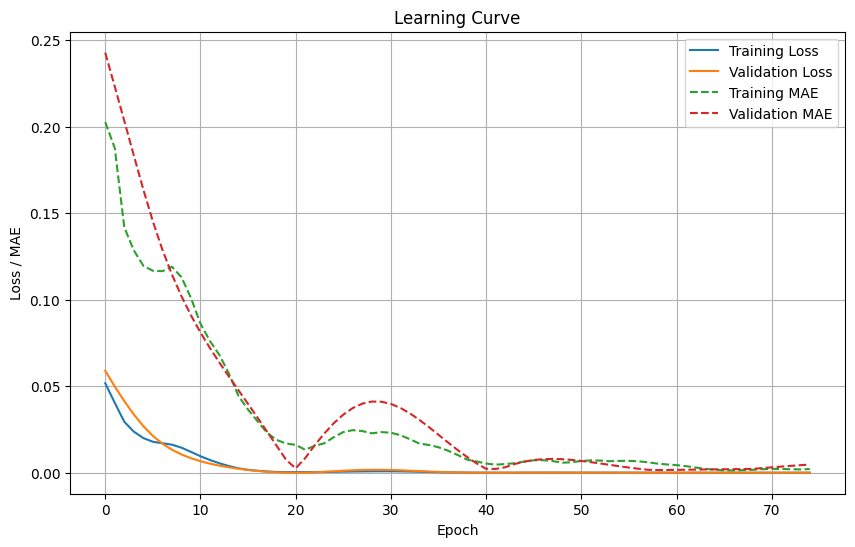